In [29]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import ipywidgets

In [30]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [31]:
def accuracy(y_hat, y):
    
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [32]:
def evaluate_accuracy(net,data_iter):
    with torch.no_grad():
        metric = Accumulator(2)
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
        return metric[0] / metric[1]

In [33]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Linear(256,10))
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

In [34]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,transform=trans,download=True)

In [35]:
batch_size = 256

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4)

In [36]:
train_metrics = []

def train(net, train_iter, loss, num_epoches, updater):
    progress_bar = ipywidgets.IntProgress(value=0,min=0,max=(num_epoches-1))
    display(progress_bar)
    for epoch in range(num_epoches):
        metric = Accumulator(3)
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat,y)
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel())
        test_accuracy = evaluate_accuracy(net,test_iter)
        train_metrics.append((epoch,metric[0]/metric[2],metric[1]/metric[2],test_accuracy))
        progress_bar.value = epoch

    for item in train_metrics[-3:-1]:
        print(f"Epoch: {item[0]}, train_loss: {item[1]}, train_accuracy: {item[2]}, test_accuracy: {item[3]}")

In [37]:
train(net,train_iter,loss,14,trainer)

IntProgress(value=0, max=13)

Epoch: 11, train_loss: 0.35485199915568033, train_accuracy: 0.8748333333333334, test_accuracy: 0.852
Epoch: 12, train_loss: 0.34933433050314583, train_accuracy: 0.8751333333333333, test_accuracy: 0.8547


(0.0, 2.0)

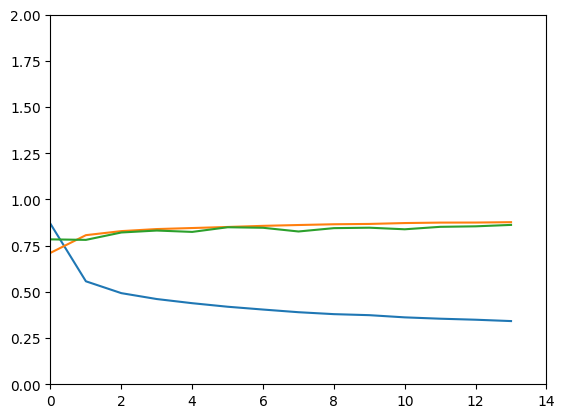

In [38]:
fig, ax = plt.subplots()
ax.plot(range(len(train_metrics)),[i[1] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[2] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[3] for i in train_metrics])
ax.set_xlim(0,len(train_metrics))
ax.set_ylim(0,2.0)


Text(0.5, 1.0, 'Real Group: 7, Calculated Group: 7')

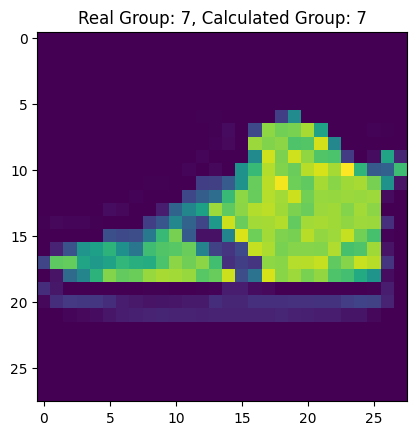

In [67]:
test_item = random.choice(mnist_test)
result = net(test_item[0])
fig, ax = plt.subplots()
ax.imshow(test_item[0].reshape((28,28)))
ax.set_title(f"Real Group: {test_item[1]}, Calculated Group: {result.argmax()}")